In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List

Take data from the preprocessing steps in [eda.ipynb](./eda.ipynb).</br>
Please extract [game_details_clean.7z](./data/game_details_clean.7z) to be able to run below.

In [2]:
pd.set_option('display.max_columns', None)
games_details = pd.read_pickle('./data/game_details_clean.pickle')

We create a function that takes as input:
* Independent Variables as inputs to a prediction model
* Dependent Variable as output to a prediction model
* The playerId who's stats we want to check
* The seasons we want to learn from and the season we want to benchmark against
* Left/Right tail boundaries to the distribution we want to receive

We use a quantile loss function, which enables us to calculate parametric distributions without specifying the distribution class - i.e. normal, gamma, etc...

In [34]:
allPerfCols = ['MIN_NUM', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TO', 'PF', 'PTS']

def getCoDistribution(inputCols: List[str], predictCol: str, playerId: int, seasonsTrain: List[int], seasonTest: int, alpha: float, makePlot: bool=True):
    trainData = games_details[(games_details['PLAYER_ID'] == playerId) & (games_details['SEASON'].isin(seasonsTrain))][inputCols + [predictCol]].values
    trainX, trainY = trainData[:,:-1], trainData[:,-1:]
    testData = games_details[(games_details['PLAYER_ID'] == playerId) & (games_details['SEASON'].isin([seasonTest]))][inputCols + [predictCol, 'GAME_DATE_EST']].values
    testX, testY, testTS = testData[:,:-2], testData[:,-2:-1], testData[:,-1:]

    XY = xgb.QuantileDMatrix(trainX, trainY)
    testXY = xgb.QuantileDMatrix(testX, testY, ref=XY)

    evals_result = dict()
    bstr = xgb.train(
        {
            "objective": "reg:quantileerror",
            "tree_method": "hist",
            "quantile_alpha": [alpha, 0.5, 1-alpha],
            "learning_rate": 0.04,
            "max_depth": 5,
        },
        XY,
        num_boost_round=100,
        early_stopping_rounds=5,
        evals=[(XY, 'Train'), (testXY, 'Test')],
        evals_result=evals_result,
        verbose_eval=False
    )

    testYpred = bstr.inplace_predict(testX)

    if makePlot:

        plt.figure(figsize=(15, 8))
        plt.plot(testTS, testY, "b.", markersize=10, label="Observation")
        plt.plot(testTS, testYpred[:, 1], "r-", label="Predicted median")
        plt.plot(testTS, testYpred[:, 2], "k-")
        plt.plot(testTS, testYpred[:, 0], "k-")
        plt.fill_between(
            np.ravel(testTS), testYpred[:, 0], testYpred[:, 2], alpha=0.4, label=f"Predicted {round(100-200*alpha)}% interval"
        )
        plt.xlabel(f"Game Date in Season {seasonTest}")
        plt.ylabel(f"{predictCol} from {inputCols}")
        plt.legend(loc="upper left")
        plt.legend(loc='upper center')
        plt.show()
    
    withinRange = ((testY[:, 0] >= testYpred[:,0]) & (testY[:, 0] <= testYpred[:,2])).sum()/len(testY)
    boundsToMedian = ((testYpred[:,2] - testYpred[:,0]).mean()/(testYpred[:,1].mean())+1e-2)
    return {"Percent In Range": withinRange, "Mean Bounds To Median": boundsToMedian}

Here we show an example output.</br>
As we saw in [eda.ipynb](./eda.ipynb), 'MIN_NUM' is a heavy factor in all other variables.</br>
So we will predicting Y given 'MIN_NUM' and X to see any correlation between X and Y.

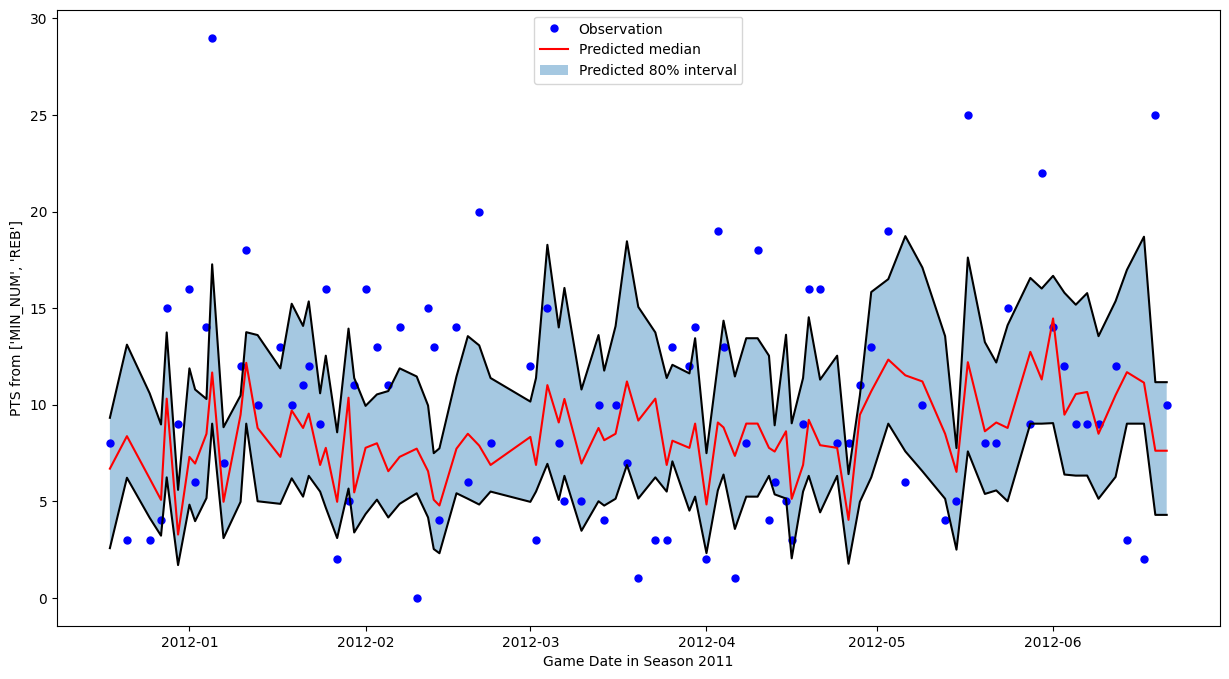

{'Percent In Range': 0.4157303370786517,
 'Mean Bounds To Median': 0.8762994503974915}

In [35]:
getCoDistribution(['MIN_NUM', 'REB'], 'PTS', 201596, [2008, 2009, 2010], 2011, 0.1)

In the above example, we see that REB is not such a good predictor.</br>
Firstly, we can compare the ratio of the 80% boundary range to the median as one possible sensitivity score. The larger this number, the lower the correlation: 0.88.</br>
Secondly, we can see if 80% of the observed data stays within the boundaries of the data. The closer we are to 80%, the more likely that our distribution model is stationary: 42%.</br>

Based on these results, 'REB' and 'PTS' are unlikely to be correlated for this player.

And the reverse, 'PTS' -> 'REB' tells the same story, although a better distributional fit.

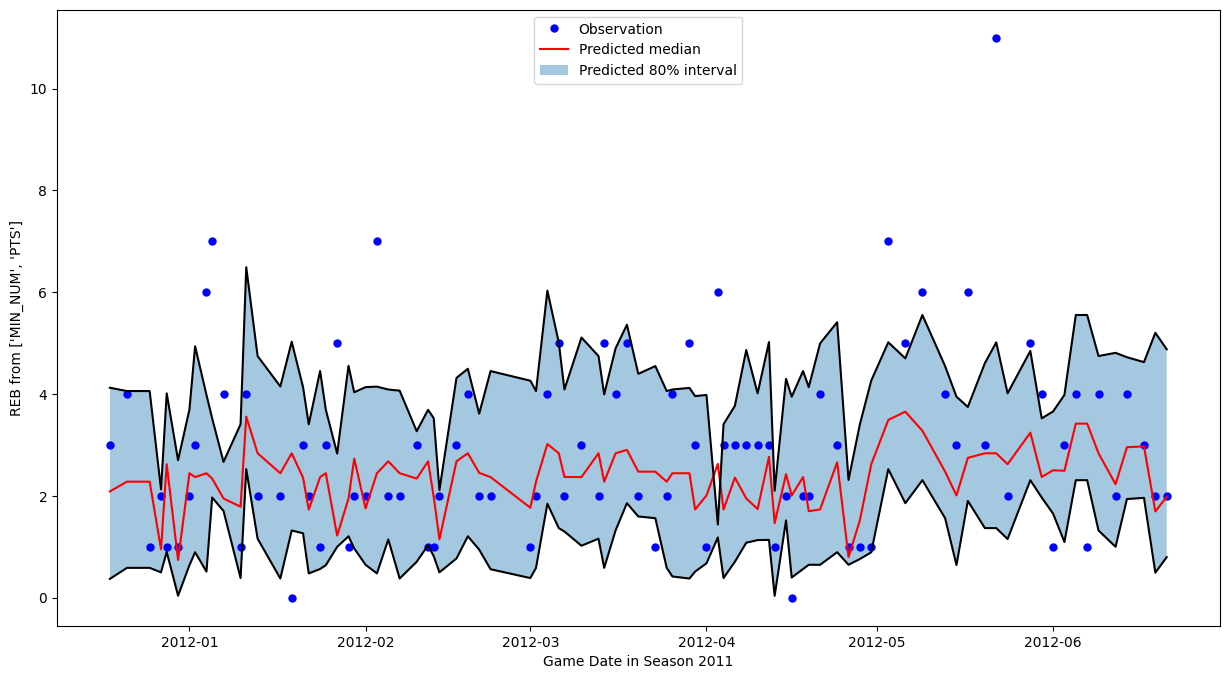

{'Percent In Range': 0.7528089887640449,
 'Mean Bounds To Median': 1.3363394832611084}

In [37]:
getCoDistribution(['MIN_NUM', 'PTS'], 'REB', 201596, [2008, 2009, 2010], 2011, 0.1)

In the next section, we sweep all pairs of stats A -> B, training a model in one season and validating it against the next season.</br>
We note that B conditional on A is not the same as A conditional on B,  meaning that we could have a one-to-many relationship which would result in better performance of one side.

In [38]:
playerId = 201596
results = dict()
seasons = games_details[(games_details['PLAYER_ID'] == playerId)][['SEASON']].groupby(by='SEASON').count().index.values
for i, season in enumerate(seasons[:-1]):
    for col1 in allPerfCols[1:]:
        for col2 in allPerfCols[1:]:
            if col1 == col2:
                continue
            results[(season, col1, col2)] = getCoDistribution(['MIN_NUM', col1], col2, 201596, [season], seasons[i+1], 0.1, False)

Below we see that the values with the best inference ability are the obvious data points:
* FGM <-> PTS (because it they have a natural $2\cdot FGM \propto PTS$)
* DREB <-> REB (possibly because this player does not do too much OREB)
* No real inference potential exists beyond this

In [40]:
sorted({key: val for key, val in results.items() if val['Percent In Range'] >= 0.6}.items(), key=lambda x: x[1]['Mean Bounds To Median'])

[((2011, 'FGM', 'PTS'),
  {'Percent In Range': 0.6176470588235294,
   'Mean Bounds To Median': 0.37936330795288087}),
 ((2012, 'PTS', 'FGM'),
  {'Percent In Range': 0.62, 'Mean Bounds To Median': 0.3825716769695282}),
 ((2012, 'FGM', 'PTS'),
  {'Percent In Range': 0.62, 'Mean Bounds To Median': 0.45447991251945496}),
 ((2010, 'PTS', 'FGM'),
  {'Percent In Range': 0.6179775280898876,
   'Mean Bounds To Median': 0.45539666175842286}),
 ((2011, 'PTS', 'FGM'),
  {'Percent In Range': 0.6764705882352942,
   'Mean Bounds To Median': 0.45944846630096436}),
 ((2013, 'PTS', 'FGM'),
  {'Percent In Range': 0.6091954022988506,
   'Mean Bounds To Median': 0.5020783638954163}),
 ((2011, 'DREB', 'REB'),
  {'Percent In Range': 0.6764705882352942,
   'Mean Bounds To Median': 0.5161795711517334}),
 ((2012, 'REB', 'DREB'),
  {'Percent In Range': 0.64, 'Mean Bounds To Median': 0.5273991918563843}),
 ((2012, 'FG3M', 'FGA'),
  {'Percent In Range': 0.64, 'Mean Bounds To Median': 0.532070586681366}),
 ((2012, 

Finally, we show here how we can estimate a parameter of the Poisson class of distributions using NGBoost, a wrapper to XGBoost.</br>
This is a particularly fitting distribution, since it models the discrete # of events whose time-to-next-event is an exponential distribution.</br>
The parameter $\lambda$ is the expected number of events.</br>
We do this estimate for a single example to show how it works and the results.

In [45]:
from xgboost_distribution import XGBDistribution

inputCols = ['MIN_NUM', 'REB']
predictCol = 'PTS'
playerId = 201596
seasonsTrain = [2008, 2009, 2010]
seasonTest = 2011

trainData = games_details[(games_details['PLAYER_ID'] == playerId) & (games_details['SEASON'].isin(seasonsTrain))][inputCols + [predictCol]].values
trainX, trainY = trainData[:,:-1], trainData[:,-1:]
testData = games_details[(games_details['PLAYER_ID'] == playerId) & (games_details['SEASON'].isin([seasonTest]))][inputCols + [predictCol, 'GAME_DATE_EST']].values
testX, testY, testTS = testData[:,:-2], testData[:,-2:-1], testData[:,-1:]

model = XGBDistribution(
    distribution="poisson",
    n_estimators=500,
    max_depth=5,
    learning_rate=0.04,
    early_stopping_rounds=5
)
model.fit(trainX, trainY, eval_set=[(testX, testY)])

[0]	validation_0-Poisson-NLL:3.95723
[1]	validation_0-Poisson-NLL:3.92051
[2]	validation_0-Poisson-NLL:3.88429
[3]	validation_0-Poisson-NLL:3.86576
[4]	validation_0-Poisson-NLL:3.84268


[5]	validation_0-Poisson-NLL:3.82112
[6]	validation_0-Poisson-NLL:3.81110
[7]	validation_0-Poisson-NLL:3.80266
[8]	validation_0-Poisson-NLL:3.79584
[9]	validation_0-Poisson-NLL:3.79050
[10]	validation_0-Poisson-NLL:3.77837
[11]	validation_0-Poisson-NLL:3.77538
[12]	validation_0-Poisson-NLL:3.77259
[13]	validation_0-Poisson-NLL:3.76789
[14]	validation_0-Poisson-NLL:3.76692
[15]	validation_0-Poisson-NLL:3.75949
[16]	validation_0-Poisson-NLL:3.75170
[17]	validation_0-Poisson-NLL:3.74457
[18]	validation_0-Poisson-NLL:3.74190
[19]	validation_0-Poisson-NLL:3.73981
[20]	validation_0-Poisson-NLL:3.73810
[21]	validation_0-Poisson-NLL:3.73854
[22]	validation_0-Poisson-NLL:3.73838
[23]	validation_0-Poisson-NLL:3.73665
[24]	validation_0-Poisson-NLL:3.73949
[25]	validation_0-Poisson-NLL:3.74008
[26]	validation_0-Poisson-NLL:3.73738
[27]	validation_0-Poisson-NLL:3.73809
[28]	validation_0-Poisson-NLL:3.74108


XGBDistribution(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device=None, distribution='poisson',
                early_stopping_rounds=5, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=None,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.04, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=5, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=500, n_jobs=None,
                num_parallel_tree=None, ...)

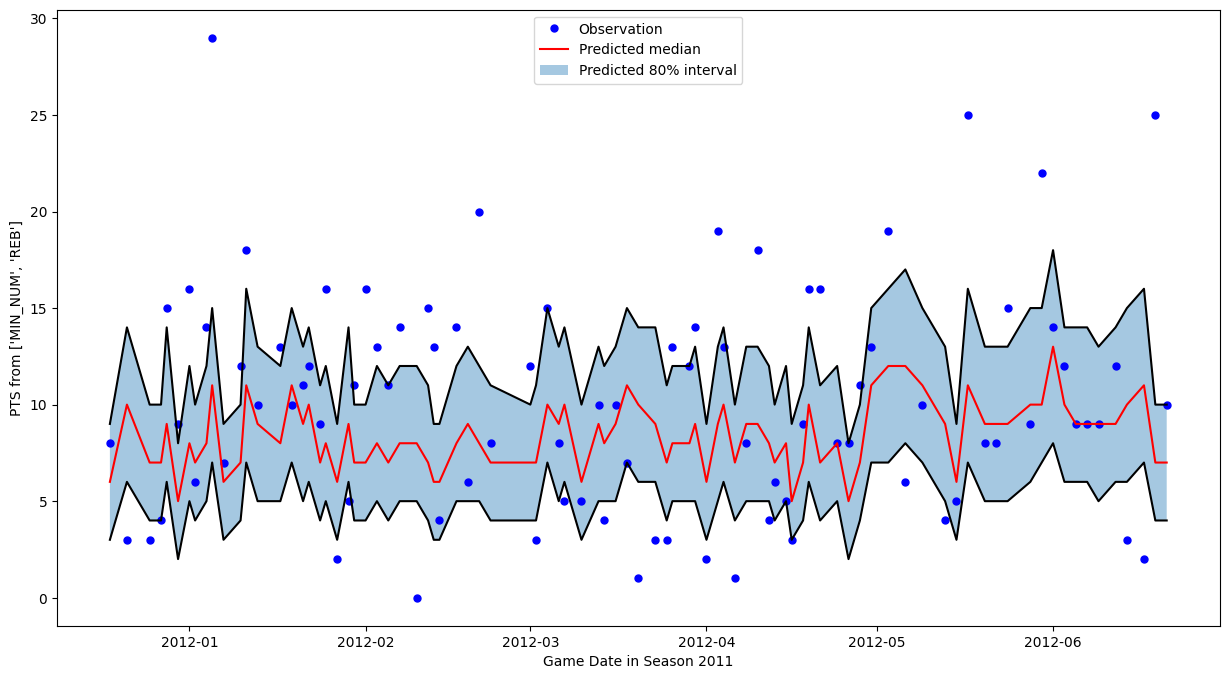

In [51]:
from scipy import stats

testYpred = model.predict(testX)
low = stats.poisson.ppf(0.10, testYpred).T
med = stats.poisson.ppf(0.50, testYpred).T
high = stats.poisson.ppf(0.90, testYpred).T

med

plt.figure(figsize=(15, 8))
plt.plot(testTS, testY, "b.", markersize=10, label="Observation")
plt.plot(testTS, med, "r-", label="Predicted median")
plt.plot(testTS, high, "k-")
plt.plot(testTS, low, "k-")
plt.fill_between(
    np.ravel(testTS), np.ravel(low), np.ravel(high), alpha=0.4, label=f"Predicted 80% interval"
)
plt.xlabel(f"Game Date in Season {seasonTest}")
plt.ylabel(f"{predictCol} from {inputCols}")
plt.legend(loc="upper left")
plt.legend(loc='upper center')
plt.show()

Comparing this to our previous approach, we see that not much has changed.</br>
This is just another approach leading to the same conclusion.